# Analysis of ChIP-seq simulation

See `chips` folder for scripts.


In [44]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt

import os

import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
sns.set_style("whitegrid")
import tempfile
import numpy as np

In [45]:
PATH = os.path.expanduser('~/data/2023_chips')
N = 5
MULTIPLIERS = [1.0, 0.7, 0.5, 0.2, 0.1]

FIGURES_DIR = f'{PATH}/pics'
! mkdir -p {FIGURES_DIR}
! rm {FIGURES_DIR}/*

# Chips models analysis

In [46]:
import json

models_df = pd.DataFrame(columns=['Modification', 'Model', 'k', 'theta', 'prc_rate', 'f', 's'],
                         dtype=object)
for modification in ['H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me3']:
    path = os.path.join(PATH, 'models', f'{modification}.json')
    with open(path) as f:
        m = json.load(f)
        k, theta, prc_rate, f, s = m['frag']['k'], m['frag']['theta'], m['pcr_rate'], \
            m['pulldown']['f'], m['pulldown']['s']
        models_df.loc[len(models_df)] = (modification, path, k, theta, prc_rate, f, s)
models_df.to_csv(os.path.join(PATH, 'models.tsv'), sep='\t', index=None)
models_df

Modification                                              Model         k  \
0      H3K27ac  /home/jetbrains/data/2023_chips/models/H3K27ac...  9.698845   
1     H3K27me3  /home/jetbrains/data/2023_chips/models/H3K27me...  7.710403   
2     H3K36me3  /home/jetbrains/data/2023_chips/models/H3K36me...  8.121823   
3      H3K4me1  /home/jetbrains/data/2023_chips/models/H3K4me1...  7.084311   
4      H3K4me3  /home/jetbrains/data/2023_chips/models/H3K4me3...  5.655991   

       theta  prc_rate         f         s  
0  28.720036       1.0  0.016691  0.543023  
1  32.211166       1.0  0.003799  0.186056  
2  31.384718       1.0  0.021185  0.649353  
3  33.604404       1.0  0.016509  0.742254  
4  37.608902       1.0  0.005437  0.738595

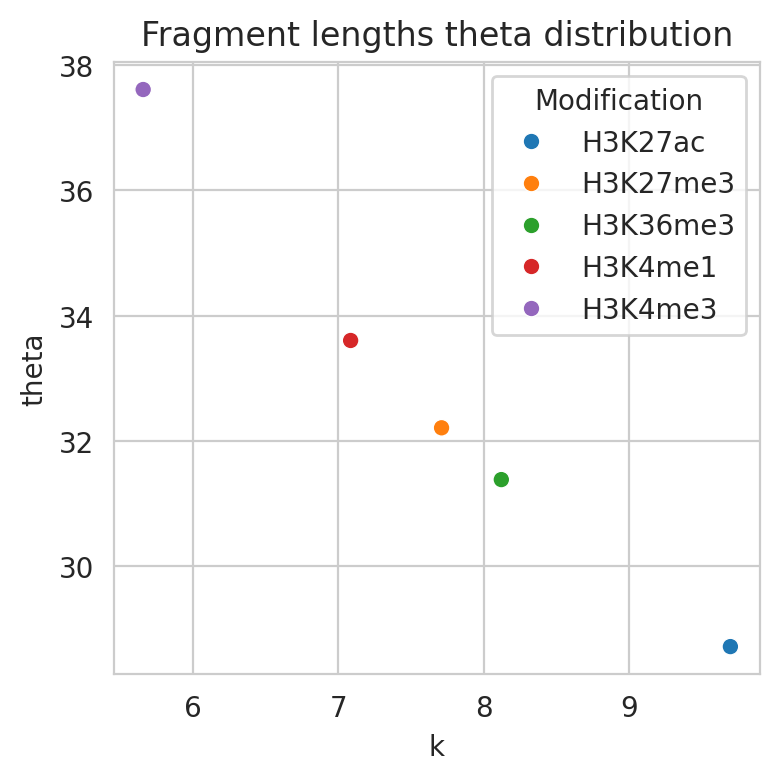

In [47]:
fig = plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='k', y='theta', hue='Modification', markers=True)
plt.title(f'Fragment lengths theta distribution')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_fragments_theta.pdf'), bbox_inches='tight', dpi=300)
plt.show()

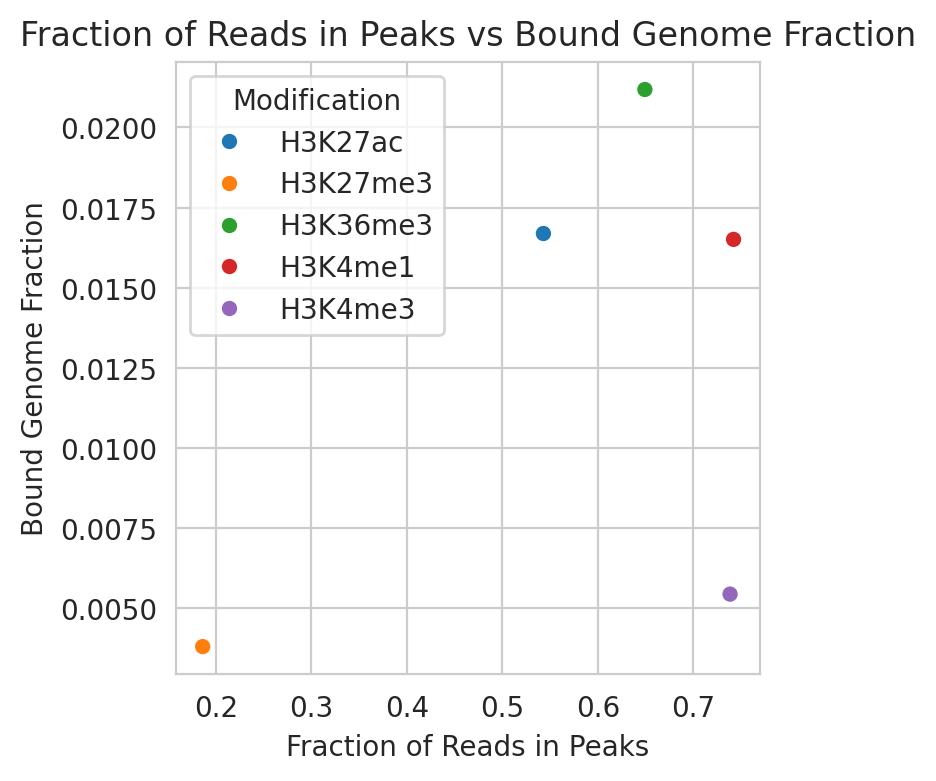

In [48]:
plt.figure(figsize=(4, 4))
sns.scatterplot(data=models_df, x='s', y='f', hue='Modification', markers=True)
plt.title(f'Fraction of Reads in Peaks vs Bound Genome Fraction')
plt.xlabel('Fraction of Reads in Peaks')
plt.ylabel('Bound Genome Fraction')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'models_frip_vs_bound_genome.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Report analysis

In [49]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file

def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    ! cat {file} | cut -f-3 | sort -k1,1 -k2,2n > {ts}
    # Fixes of problems with peakseq output
    ! sed -E -i 's/[[:space:]]+/\t/g' {ts}
    ! sed -E -i 's/\t$//g' {ts}
    return ts

In [50]:
original_peaks = {
    'H3K4me3': PATH + '/peaks/H3K4me3_q0.05_peaks.narrowPeak',
    'H3K27ac': PATH + '/peaks/H3K27ac_broad0.1_peaks.broadPeak',
    'H3K4me1': PATH + '/peaks/H3K4me1_broad0.1_peaks.broadPeak',
    'H3K27me3' : PATH + '/peaks/H3K27me3-W200-G600-islands-summary-FDR0.01',
    'H3K36me3': PATH + '/peaks/H3K36me3-W200-G600-islands-summary-FDR0.01',
}

In [51]:
import glob
sampled_peaks = {}
for m in ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']:
    for n in range(1, N + 1):
        sampled_peaks[(m, n)] = glob.glob(PATH + f'/fastq/{m}_*_{n}.bed')[0]
sampled_peaks

{('H3K4me3', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_1.bed',
 ('H3K4me3', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_2.bed',
 ('H3K4me3', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_3.bed',
 ('H3K4me3', 4): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_4.bed',
 ('H3K4me3', 5): '/home/jetbrains/data/2023_chips/fastq/H3K4me3_chr15_5.bed',
 ('H3K27ac', 1): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_1.bed',
 ('H3K27ac', 2): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_2.bed',
 ('H3K27ac', 3): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_3.bed',
 ('H3K27ac', 4): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_4.bed',
 ('H3K27ac', 5): '/home/jetbrains/data/2023_chips/fastq/H3K27ac_chr15_5.bed',
 ('H3K4me1', 1): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_1.bed',
 ('H3K4me1', 2): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_chr15_2.bed',
 ('H3K4me1', 3): '/home/jetbrains/data/2023_chips/fastq/H3K4me1_

In [52]:
from itertools import product
def load_peaks(path, suffix):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'n', 'multiplier'], dtype=object)
    for (m, n, mult) in tqdm(product(
            ['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], 
            range(1, N + 1), 
            MULTIPLIERS)):
        res = glob.glob(f'{path}/{m}*_{n}_{mult}*{suffix}')
        if len(res) > 1:
            print(f'WARNING, more than 1 found for {path} {suffix}')
        for f in res:
            df_fdr.loc[len(df_fdr)] = (f, m, n, mult)
    return df_fdr

# Load peaks

In [53]:
df_macs2 = load_peaks(PATH + '/macs2', '.narrowPeak')
df_macs2['tool'] = 'MACS2'
print('MACS2', len(df_macs2))

df_macs2broad = load_peaks(PATH + '/macs2', '.broadPeak')
df_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_macs2broad))

df_sicer = load_peaks(PATH + '/sicer', 'FDR0.01')
df_sicer['tool'] = 'SICER'
print('SICER', len(df_sicer))

df_omnipeak = load_peaks(PATH + '/omnipeak', '.peak')
df_omnipeak['tool'] = 'Omnipeak'
print('Omnipeak', len(df_omnipeak))

df_homer = load_peaks(PATH + '/homer', '.peaks')
df_homer['tool'] = 'HOMER'
print('HOMER', len(df_homer))

df_hotspot = load_peaks(PATH + '/hotspot', '.peak')
df_hotspot['tool'] = 'Hotspot'
print('Hotspot', len(df_hotspot))

df_peakseq = load_peaks(PATH + '/peakseq', '.narrowPeak')
df_peakseq['tool'] = 'Peakseq'
print('Peakseq', len(df_peakseq))

df_lanceotron = load_peaks(PATH + '/lanceotron', '.bed')
df_lanceotron['tool'] = 'LanceOtron'
print('LanceOtron', len(df_lanceotron))


df_peaks = pd.concat([df_macs2, df_macs2broad, df_omnipeak, df_sicer, df_homer, df_hotspot, df_peakseq, df_lanceotron]).reset_index(drop=True)
df_peaks['quality'] = [f'{int(m * 100)}%' for m in df_peaks['multiplier']]
df_peaks.sample(5)

0it [00:00, ?it/s]

MACS2 150


0it [00:00, ?it/s]

MACS2 broad 150


0it [00:00, ?it/s]

SICER 150


0it [00:00, ?it/s]

Omnipeak 150


0it [00:00, ?it/s]

HOMER 150


0it [00:00, ?it/s]

Hotspot 150


0it [00:00, ?it/s]

Peakseq 150


0it [00:00, ?it/s]

LanceOtron 150


file modification  n  \
251  /home/jetbrains/data/2023_chips/macs2/H3K36me3...     H3K36me3  1   
699  /home/jetbrains/data/2023_chips/homer/H3K27me3...     H3K27me3  5   
364  /home/jetbrains/data/2023_chips/omnipeak/H3K4m...      H3K4me1  3   
88   /home/jetbrains/data/2023_chips/macs2/H3K27me3...     H3K27me3  3   
237  /home/jetbrains/data/2023_chips/macs2/H3K27me3...     H3K27me3  3   

     multiplier         tool quality  
251         0.7  MACS2 broad     70%  
699         0.1        HOMER     10%  
364         0.1     Omnipeak     10%  
88          0.2        MACS2     20%  
237         0.5  MACS2 broad     50%

# Estimate overlap with ground truth peaks

In [54]:
tf = tempfile.mktemp()
t = []
for _, (file, m, n) in tqdm(list(df_peaks[['file', 'modification', 'n']].iterrows())):
    true_peaks_file = sampled_peaks[(m, n)]
    true_peaks = lines(true_peaks_file)
    true_length = bedl(true_peaks_file).sum()
    peaks = lines(file)
    length = bedl(file).sum()
    # print(file, true_peaks_file)
    true_peaks_file_s = sorted_file(true_peaks_file)
    file_s = sorted_file(file)
    # print(file_s, true_peaks_file_s)
    ! bedtools intersect -a {true_peaks_file_s} -b {file_s} -wa -u > {tf}
    true_overlap = lines(tf)
    ! bedtools intersect -b {true_peaks_file_s} -a {file_s} -wa -u > {tf}
    overlap = lines(tf)
    ! bedtools intersect -a {true_peaks_file_s} -b {file_s} -wo > {tf}
    overlap_len = int(last_col(tf).sum())
    ! rm {true_peaks_file_s} {file_s} {tf}
    t.append((true_peaks_file, true_peaks, true_length, peaks, length, true_overlap, overlap, overlap_len))
    
t = pd.DataFrame(t, columns=['true_peaks_file', 'true_peaks', 'true_length',
                             'peaks', 'length', 
                             'true_overlap', 'overlap', 'overlap_len'])
for c in t.columns:
    df_peaks[c] = list(t[c])
del t

df_peaks['Precision'] = df_peaks['overlap'] / df_peaks['peaks']
df_peaks['Recall'] = df_peaks['true_overlap'] / df_peaks['true_peaks']
df_peaks['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(df_peaks['Precision'], df_peaks['Recall'])]
df_peaks['Jaccard'] = df_peaks['overlap_len'] / (df_peaks['true_length'] + df_peaks['length'] - df_peaks['overlap_len'])


df_peaks.sample(5)

  0%|          | 0/1200 [00:00<?, ?it/s]

file modification  n  \
998   /home/jetbrains/data/2023_chips/peakseq/H3K27m...     H3K27me3  5   
657   /home/jetbrains/data/2023_chips/homer/H3K4me1_...      H3K4me1  2   
864   /home/jetbrains/data/2023_chips/hotspot/H3K36m...     H3K36me3  3   
715   /home/jetbrains/data/2023_chips/homer/H3K36me3...     H3K36me3  4   
1100  /home/jetbrains/data/2023_chips/lanceotron/H3K...      H3K4me1  1   

      multiplier        tool quality  \
998          0.2     Peakseq     20%   
657          0.5       HOMER     50%   
864          0.1     Hotspot     10%   
715          1.0       HOMER    100%   
1100         1.0  LanceOtron    100%   

                                        true_peaks_file  true_peaks  \
998   /home/jetbrains/data/2023_chips/fastq/H3K27me3...         500   
657   /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   
864   /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
715   /home/jetbrains/data/2023_chips/fastq/H3K36me3...         500   
1100  /home/jetbrains/data/2023_chips/fastq/H3K4me1_...         500   

      true_length  peaks      length  true_overlap  overlap  overlap_len  \
998       3039100   1253   1662350.0           294     1252      1661510   
657        587706   1578   1296375.0           389      389       506578   
864       6816700  62706  52876027.0           500     6899      5981500   
715       7228300    603   6392264.0           424      603      6342419   
1100       618764    907    840077.0           498      523       610563   

      Precision  Recall        F1   Jaccard  
998    0.999202   0.588  0.740335  0.546560  
657    0.246515   0.778  0.374398  0.367751  
864    0.110021   1.000  0.198233  0.111364  
715    1.000000   0.848  0.917749  0.871433  
1100   0.576626   0.996  0.730396  0.719768

# Peaks number and lengths

In [55]:
TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'HOMER', 'Hotspot', 'Peakseq', 'LanceOtron', 'Omnipeak']
palette = plt.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

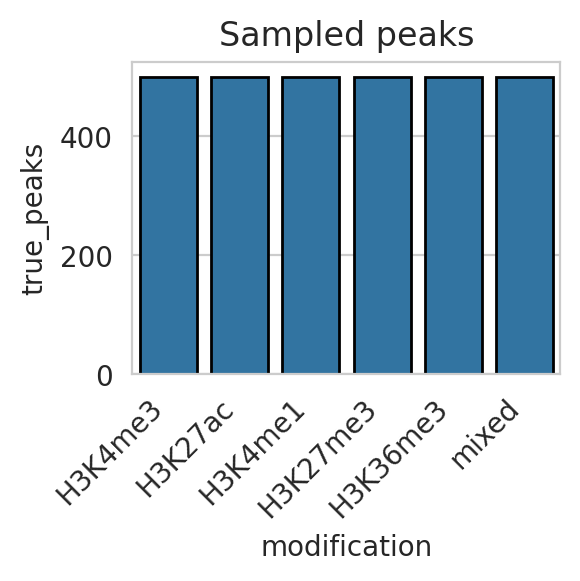

In [56]:
fig = plt.figure(figsize=(3, 3))
sns.barplot(data=df_peaks, x="modification", y="true_peaks",
            # capsize=.1, err_kws={'linewidth': 2},
            edgecolor="black",
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
plt.xticks(rotation=45, ha='right')
plt.title('Sampled peaks')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_number.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [57]:
ts = []
for m, file in original_peaks.items():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_original = pd.concat(ts).reset_index(drop=True)
del ts
t_original

length modification
0         672      H3K4me3
1         409      H3K4me3
2        1367      H3K4me3
3         303      H3K4me3
4         236      H3K4me3
...       ...          ...
99995   56199     H3K36me3
99996    3999     H3K36me3
99997    6999     H3K36me3
99998    3199     H3K36me3
99999    1399     H3K36me3

[100000 rows x 2 columns]

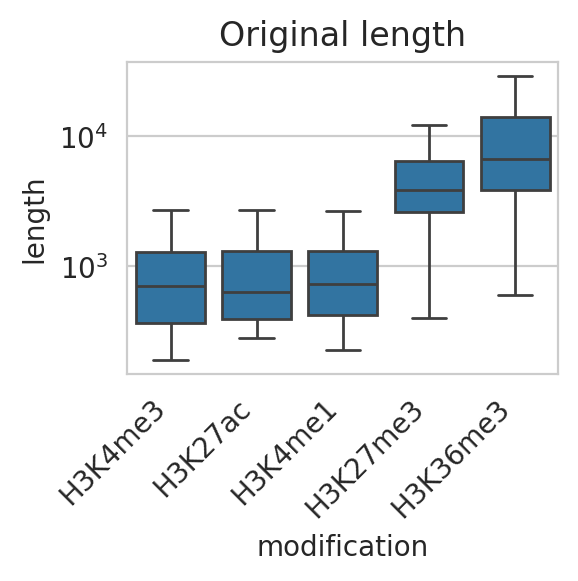

In [58]:
fig = plt.figure(figsize=(3, 3))
ax = plt.axes()
sns.boxplot(data=t_original, x="modification", y="length", showfliers=False,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'],
            ax=ax)
ax.set(yscale='log')
plt.xticks(rotation=45, ha='right')
plt.title('Original length')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

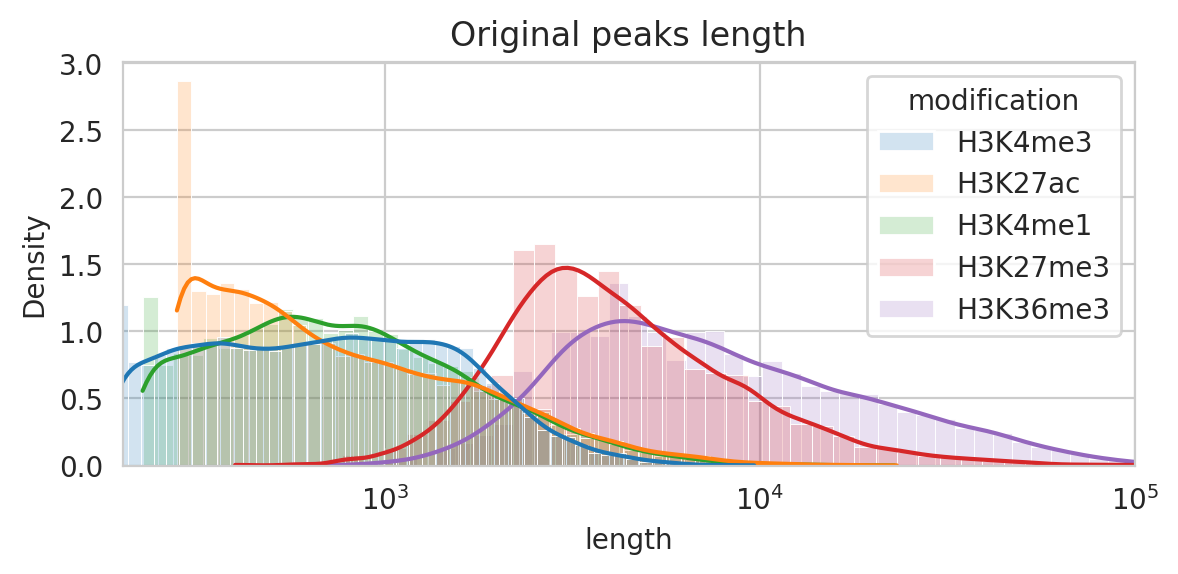

In [59]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
g_results = sns.histplot(data=t_original, x='length', hue='modification', ax=ax,
                         stat='density', common_bins=False, common_norm=False,
                         bins=50, kde=True, log_scale=True, alpha=0.2,
                         hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3'])
g_results.set(xscale='log')
g_results.set_xlim(200, 1e5)
ax.title.set_text('Original peaks length')
plt.savefig(os.path.join(FIGURES_DIR, f'true_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

In [60]:
ts = []
for _, (m, file) in df_peaks[['modification', 'true_peaks_file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    ts.append(t)
t_true_peaks = pd.concat(ts).reset_index(drop=True)
del ts
t_true_peaks

length modification
0          387      H3K4me3
1         1204      H3K4me3
2          211      H3K4me3
3          412      H3K4me3
4          371      H3K4me3
...        ...          ...
599995     351        mixed
599996    7999        mixed
599997     529        mixed
599998     424        mixed
599999     377        mixed

[600000 rows x 2 columns]

/tmp/ipykernel_674383/951696089.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])


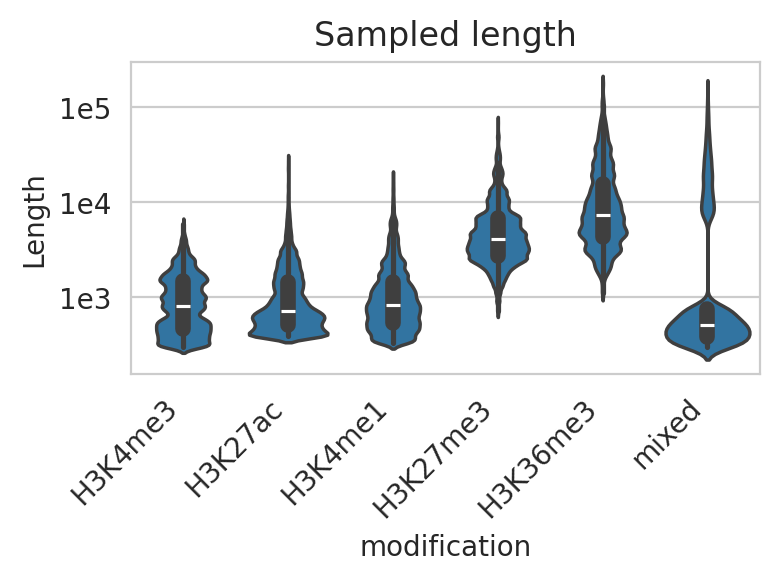

In [61]:
fig = plt.figure(figsize=(4, 3))
ax = plt.axes()
t_true_peaks['log_length'] = np.log10(t_true_peaks['length'] + 100)
sns.violinplot(data=t_true_peaks, x="modification", y="log_length",
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
               ax=ax)
plt.xticks(rotation=45, ha='right')
ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])
plt.ylabel('Length')
plt.title('Sampled length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

/tmp/ipykernel_674383/3808701143.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])


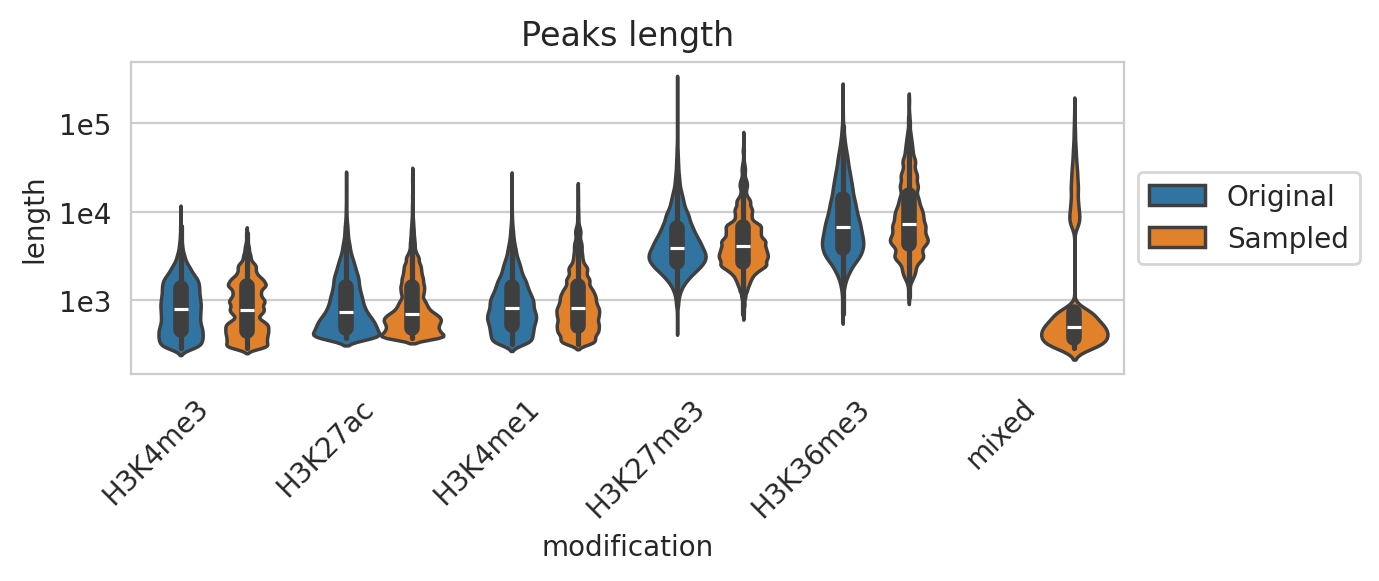

In [62]:
t_original['type'] = 'Original'
t_true_peaks['type'] = 'Sampled'
t = pd.concat([t_original, t_true_peaks]).reset_index(drop=True)
t['log_length'] = np.log10(t['length'] + 100)
plt.figure(figsize=(7, 3))
ax = plt.axes()
sns.violinplot(data=t,
               x="modification", y="log_length",
               # showfliers=False,
               hue='type', hue_order=['Original', 'Sampled'],
               order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
               ax=ax)
# Put a legend to the right of the current axix
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=45, ha='right')
# ax.set(yscale='log')
ax.set_yticklabels(['', '1e3', '1e4', '1e5', ''])
plt.ylabel('length')
plt.title('Peaks length')
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

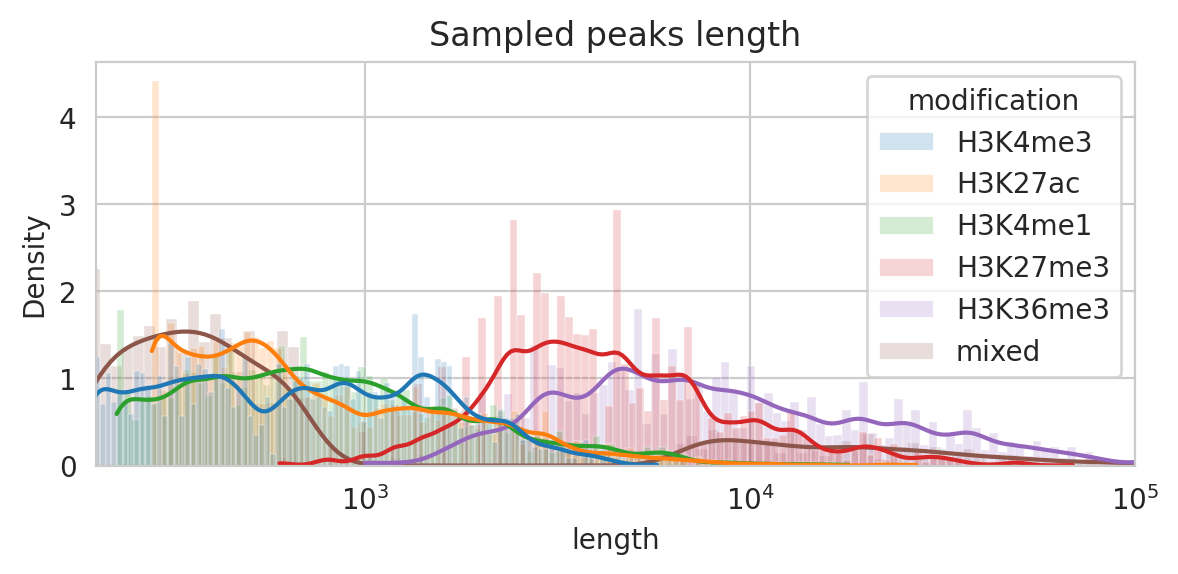

In [63]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.histplot(data=t_true_peaks, x='length', hue='modification',
             stat='density', common_bins=False, common_norm=False,
             bins=100, kde=True, log_scale=True, alpha=0.2,
             hue_order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
             ax=ax)
ax.set(xscale='log')
ax.set_xlim(200, 1e5)
ax.title.set_text('Sampled peaks length')
# Put a legend to the right of the current axix
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(os.path.join(FIGURES_DIR, f'sampled_peaks_lengths2.pdf'), bbox_inches='tight', dpi=300)
plt.tight_layout()
plt.show()

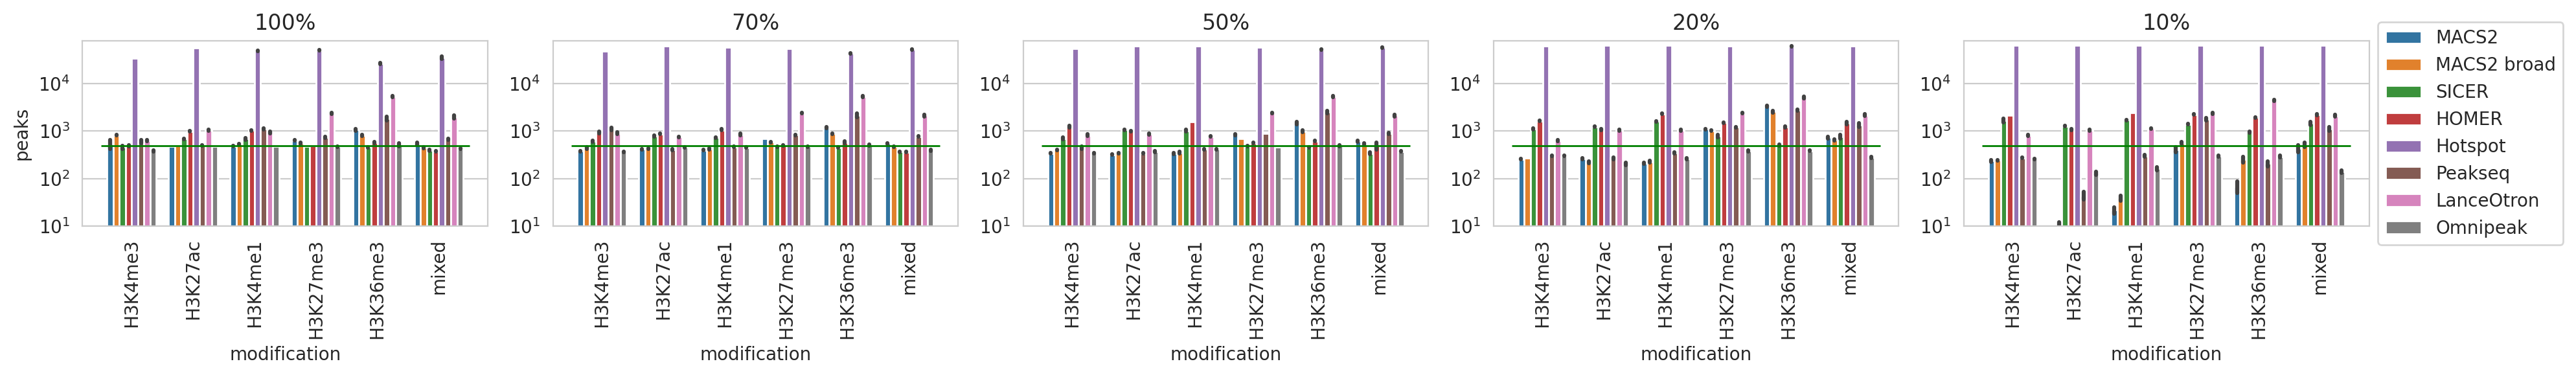

In [64]:
plt.figure(figsize=(20, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="peaks", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    ax.set(yscale='log')
    ax.set_ylim(bottom=10, top=80_000)
    ax.hlines(y = 500, xmin = -0.5, xmax = 5.5, color = 'green', linestyle = '')
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

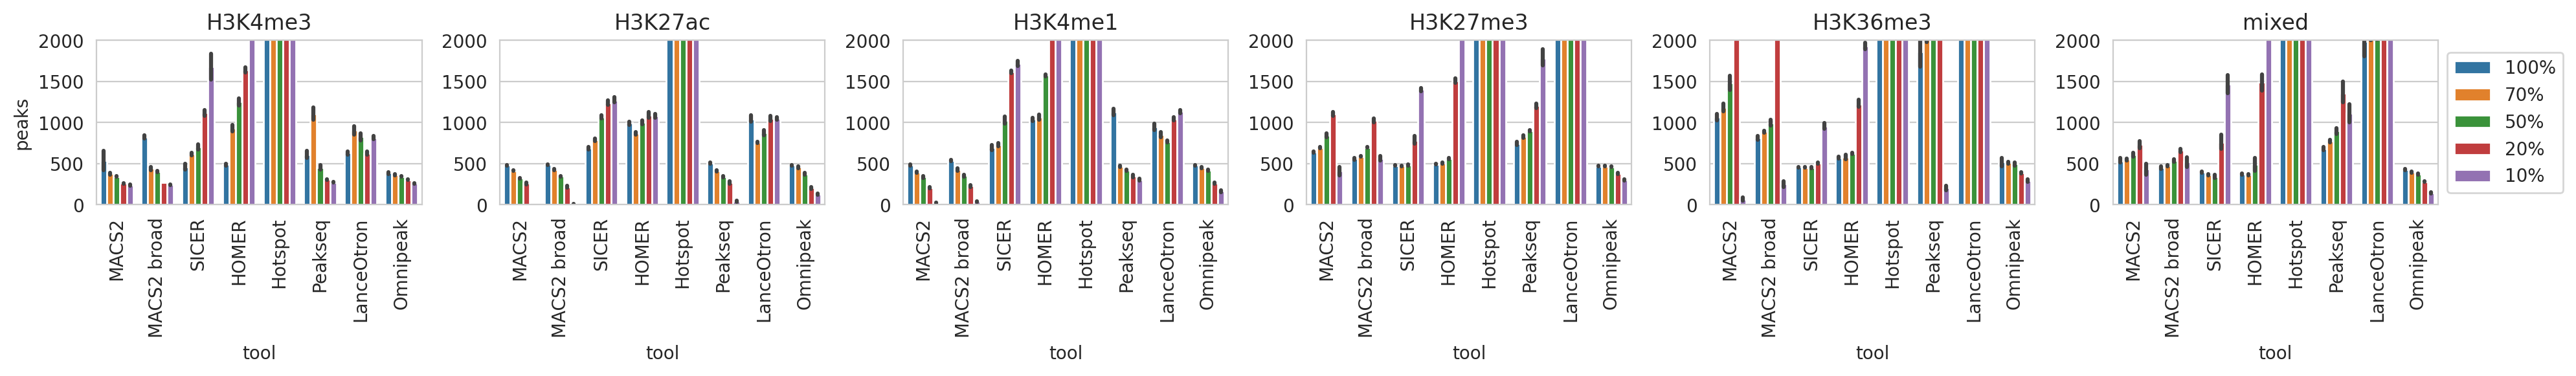

In [65]:
plt.figure(figsize=(20, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['modification'] == m], x="tool", y="peaks", hue='quality', ax=ax,
                hue_order=['100%', '70%', '50%', '20%', '10%'],
                order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{m}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
    ax.set_ylim(0, 2_000)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'peaks.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [66]:
ts = []
for _, (m, q, tool, file) in df_peaks[['modification', 'quality', 'tool', 'file']].iterrows():
    lengths = bedl(file)
    t = pd.DataFrame(dict(length=lengths))
    t = t.sample(min(len(t), 20_000))
    t['modification'] = m
    t['quality'] = q
    t['tool'] = tool
    ts.append(t)
t = pd.concat(ts).reset_index(drop=True)
del ts
t

length modification quality        tool
0         197.0      H3K4me3    100%       MACS2
1         214.0      H3K4me3    100%       MACS2
2        1170.0      H3K4me3    100%       MACS2
3         881.0      H3K4me3    100%       MACS2
4         193.0      H3K4me3    100%       MACS2
...         ...          ...     ...         ...
3975989   403.0        mixed     10%  LanceOtron
3975990  1951.0        mixed     10%  LanceOtron
3975991   335.0        mixed     10%  LanceOtron
3975992   286.0        mixed     10%  LanceOtron
3975993   657.0        mixed     10%  LanceOtron

[3975994 rows x 4 columns]

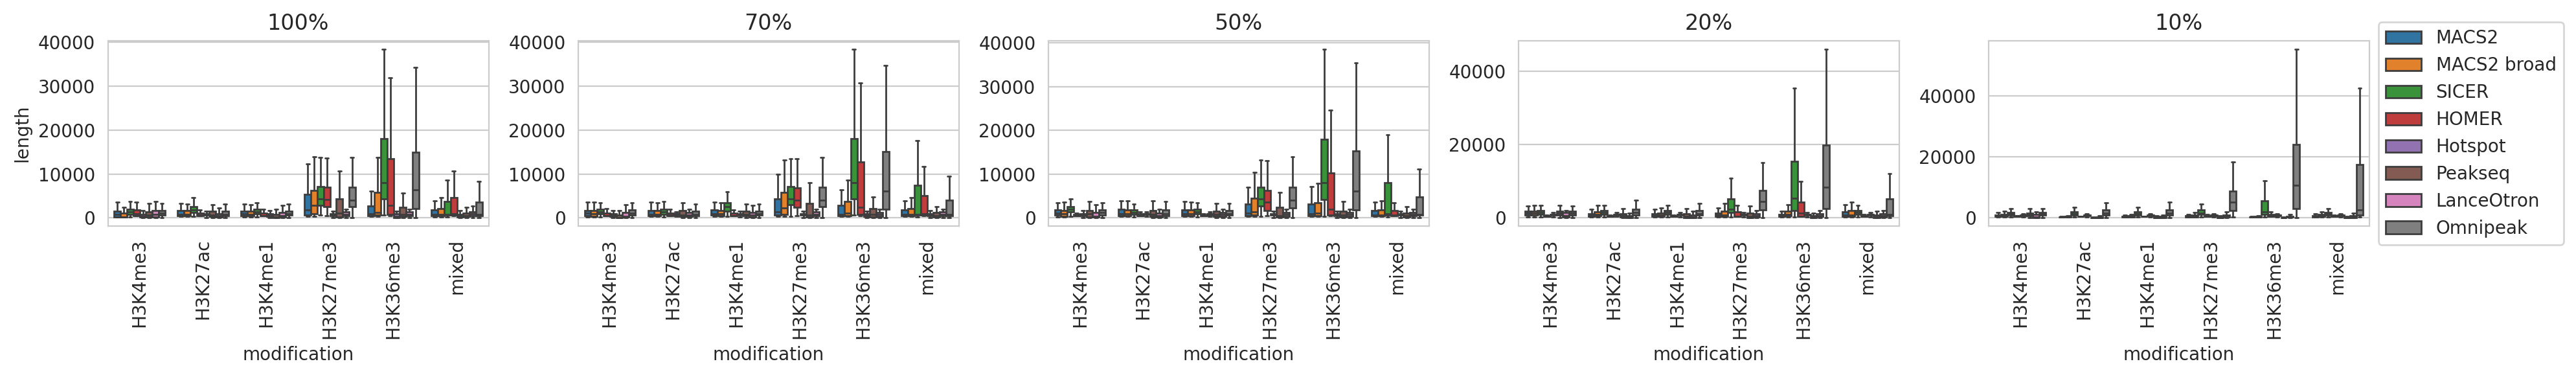

In [67]:
plt.figure(figsize=(20, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.boxplot(data=t[t['quality']==q], x="modification", y="length", hue='tool', showfliers=False, ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'lengths.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard, precision, recall, F1

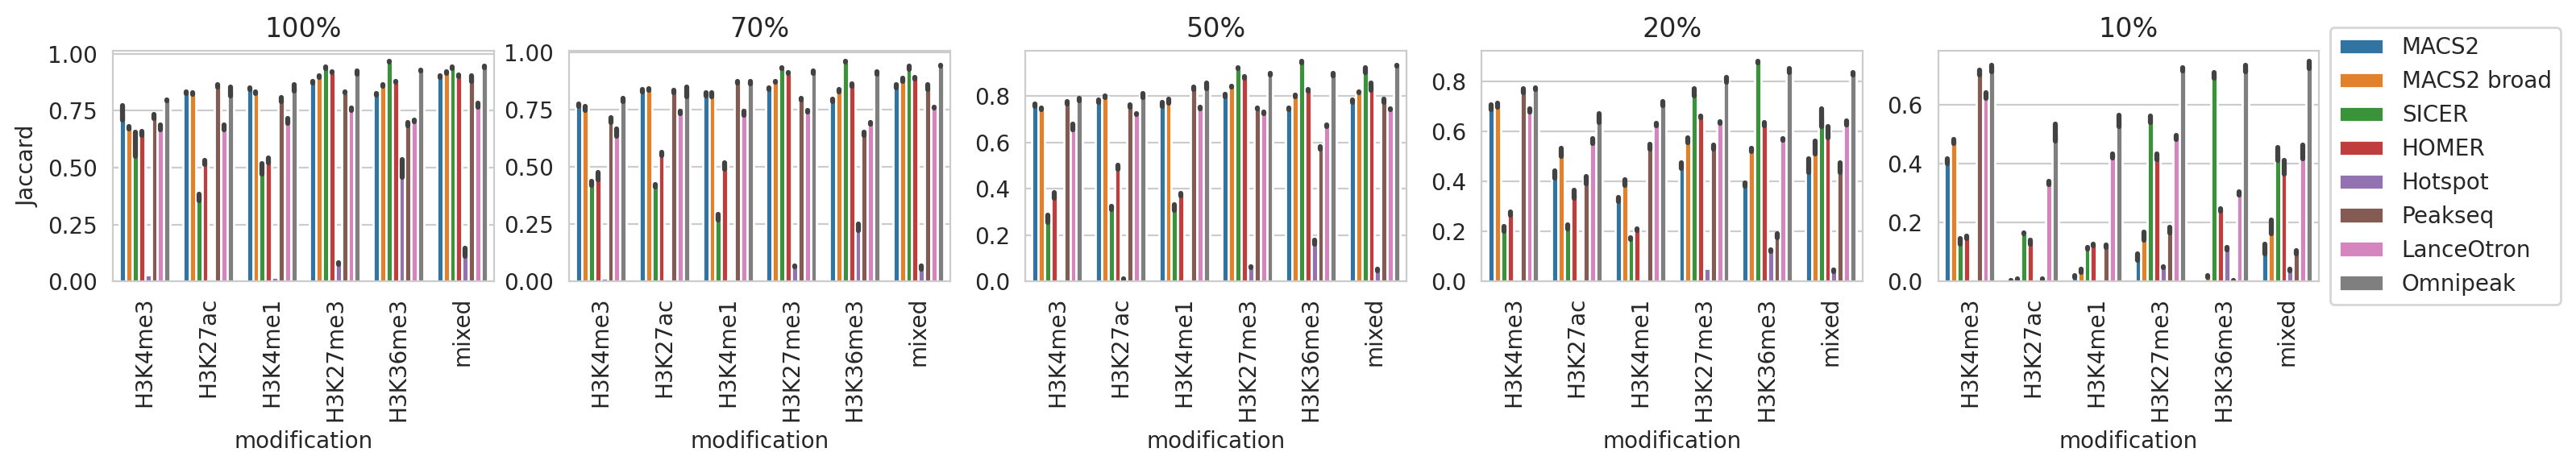

In [68]:
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
for i, q in enumerate(df_peaks['quality'].unique()):
    ax = axs[i]
    sns.barplot(data=df_peaks[df_peaks['quality'] == q], x="modification", y="Jaccard", hue='tool', ax=ax,
                order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
                hue_order=TOOLS)
    ax.xaxis.set_tick_params(rotation=90)
    ax.set_title(f'{q}')
    # Put a legend to the right of the current axis
    if i == len(axs) - 1:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard.pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [69]:
df_peaks0 = df_peaks.copy()
# Add 0.0 multiplier
for m, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], TOOLS):
    row = [None, m, None, 0.0, tool, '0%'] + [None] * (len(df_peaks.columns) - 7) + [0.0]
    df_peaks0.loc[len(df_peaks0)] = row
df_peaks0

/tmp/ipykernel_674383/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_peaks0.loc[len(df_peaks0)] = row
/tmp/ipykernel_674383/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_peaks0.loc[len(df_peaks0)] = row
/tmp/ipykernel_674383/2697057653.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain t

file modification     n  \
0     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
1     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
2     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
3     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
4     /home/jetbrains/data/2023_chips/macs2/H3K4me3_...      H3K4me3     1   
...                                                 ...          ...   ...   
1243                                               None        mixed  None   
1244                                               None        mixed  None   
1245                                               None        mixed  None   
1246                                               None        mixed  None   
1247                                               None        mixed  None   

      multiplier        tool quality  \
0            1.0       MACS2    100%   
1            0.7       MACS2     70%   
2            0.5       MACS2     50%   
3            0.2       MACS2     20%   
4            0.1       MACS2     10%   
...          ...         ...     ...   
1243         0.0       HOMER      0%   
1244         0.0     Hotspot      0%   
1245         0.0     Peakseq      0%   
1246         0.0  LanceOtron      0%   
1247         0.0    Omnipeak      0%   

                                        true_peaks_file true_peaks  \
0     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
1     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
2     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
3     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
4     /home/jetbrains/data/2023_chips/fastq/H3K4me3_...        500   
...                                                 ...        ...   
1243                                               None       None   
1244                                               None       None   
1245                                               None       None   
1246                                               None       None   
1247                                               None       None   

     true_length peaks    length true_overlap overlap overlap_len  Precision  \
0         446051   724  553939.0          398     401      408267   0.553867   
1         446051   394  463046.0          359     367      393356   0.931472   
2         446051   345  432379.0          329     335      378729   0.971014   
3         446051   258  358434.0          253     256      327744   0.992248   
4         446051   238  195186.0          184     235      187942   0.987395   
...          ...   ...       ...          ...     ...         ...        ...   
1243        None  None       NaN         None    None        None        NaN   
1244        None  None       NaN         None    None        None        NaN   
1245        None  None       NaN         None    None        None        NaN   
1246        None  None       NaN         None    None        None        NaN   
1247        None  None       NaN         None    None        None        NaN   

      Recall        F1   Jaccard  
0      0.796  0.653217  0.689963  
1      0.718  0.810922  0.762701  
2      0.658  0.784434  0.757911  
3      0.506  0.670219  0.687468  
4      0.368  0.536170  0.414613  
...      ...       ...       ...  
1243     NaN       NaN  0.000000  
1244     NaN       NaN  0.000000  
1245     NaN       NaN  0.000000  
1246     NaN       NaN  0.000000  
1247     NaN       NaN  0.000000  

[1248 rows x 18 columns]

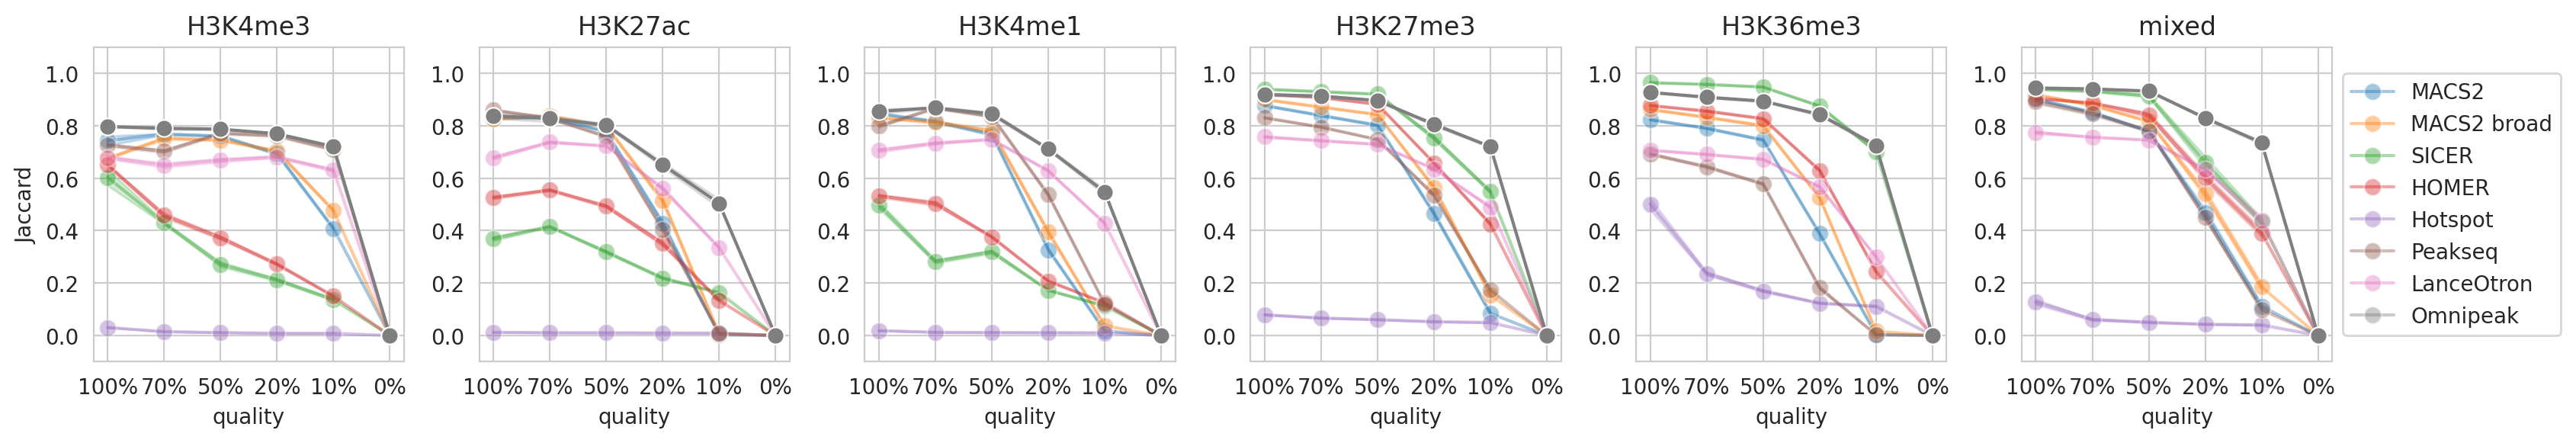

In [70]:
plt.figure(figsize=(17, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=df_peaks0[(df_peaks0['modification'] == m) &
                                (df_peaks0['tool'] != 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 alpha=0.4,
                 marker='o', markersize=8)
    sns.lineplot(data=df_peaks0[(df_peaks0['modification'] == m) &
                                (df_peaks0['tool'] == 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 marker='o', markersize=8,
                 legend=False)
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

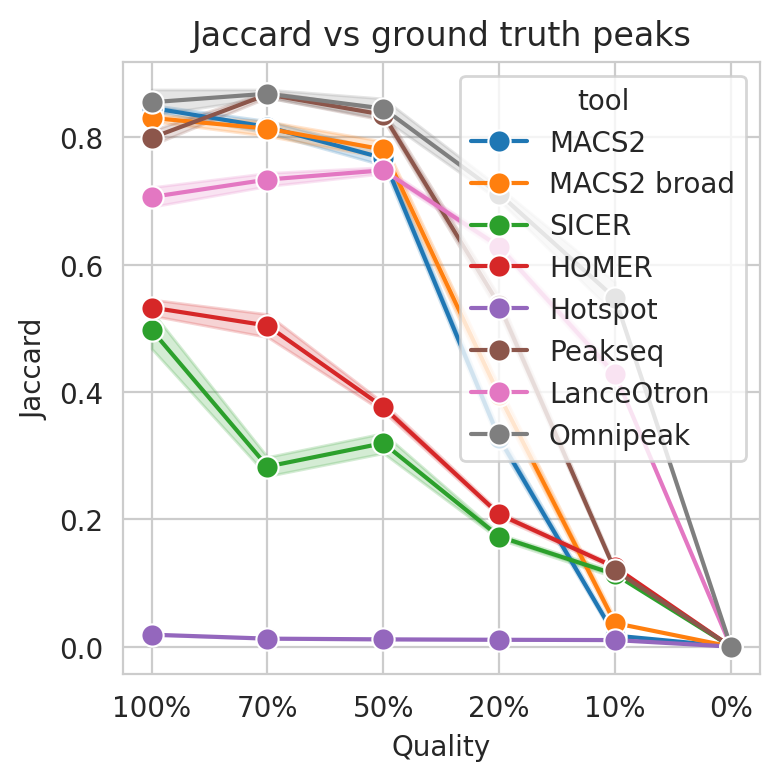

In [71]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks0[df_peaks0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

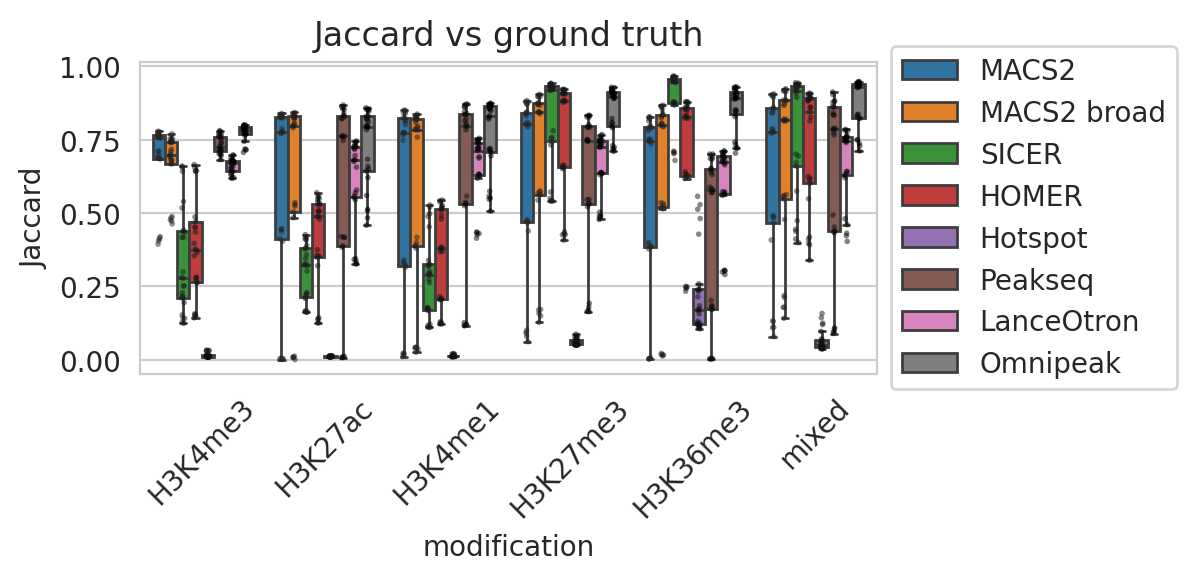

In [72]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
sns.boxplot(data=df_peaks[df_peaks['multiplier'] > 0],
            x='modification', y='Jaccard', hue='tool',
            hue_order=TOOLS,
            palette=TOOLS_PALETTE,
            showfliers=False,
            ax=ax)
sns.stripplot(data=df_peaks[df_peaks['multiplier'] > 0],
              x='modification', y='Jaccard', hue='tool',
              dodge=True, size=2, color="black", alpha=0.5, palette='dark:black',
              hue_order=TOOLS,
              legend=False,
              ax=ax)
ax.set_title('Jaccard vs ground truth')
ax.xaxis.set_tick_params(rotation=45)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard3.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Jaccard AUC vs quality

In [73]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

modification  n     tool       AUC
31       H3K27ac  4    SICER  0.306405
127      H3K4me1  1    SICER  0.278214
238        mixed  5  Peakseq  0.633454

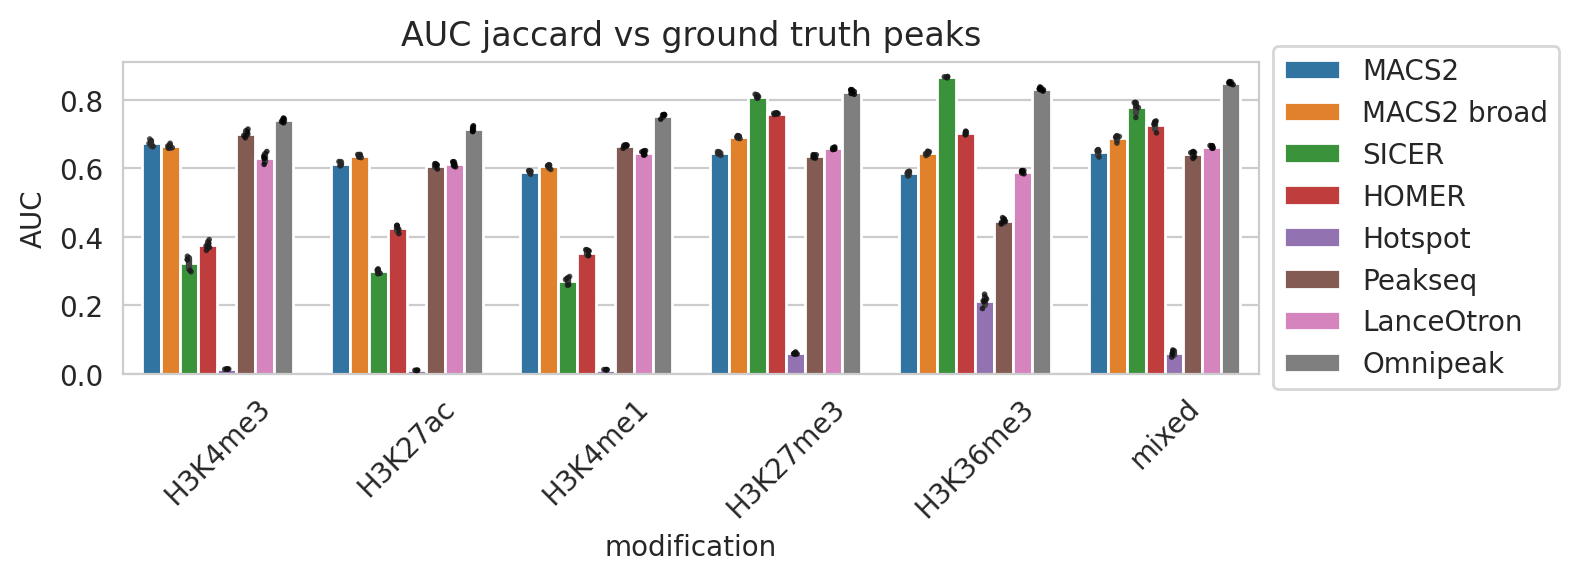

In [74]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs ground truth peaks')
sns.barplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
            # capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=dfjaccardauc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

Precision


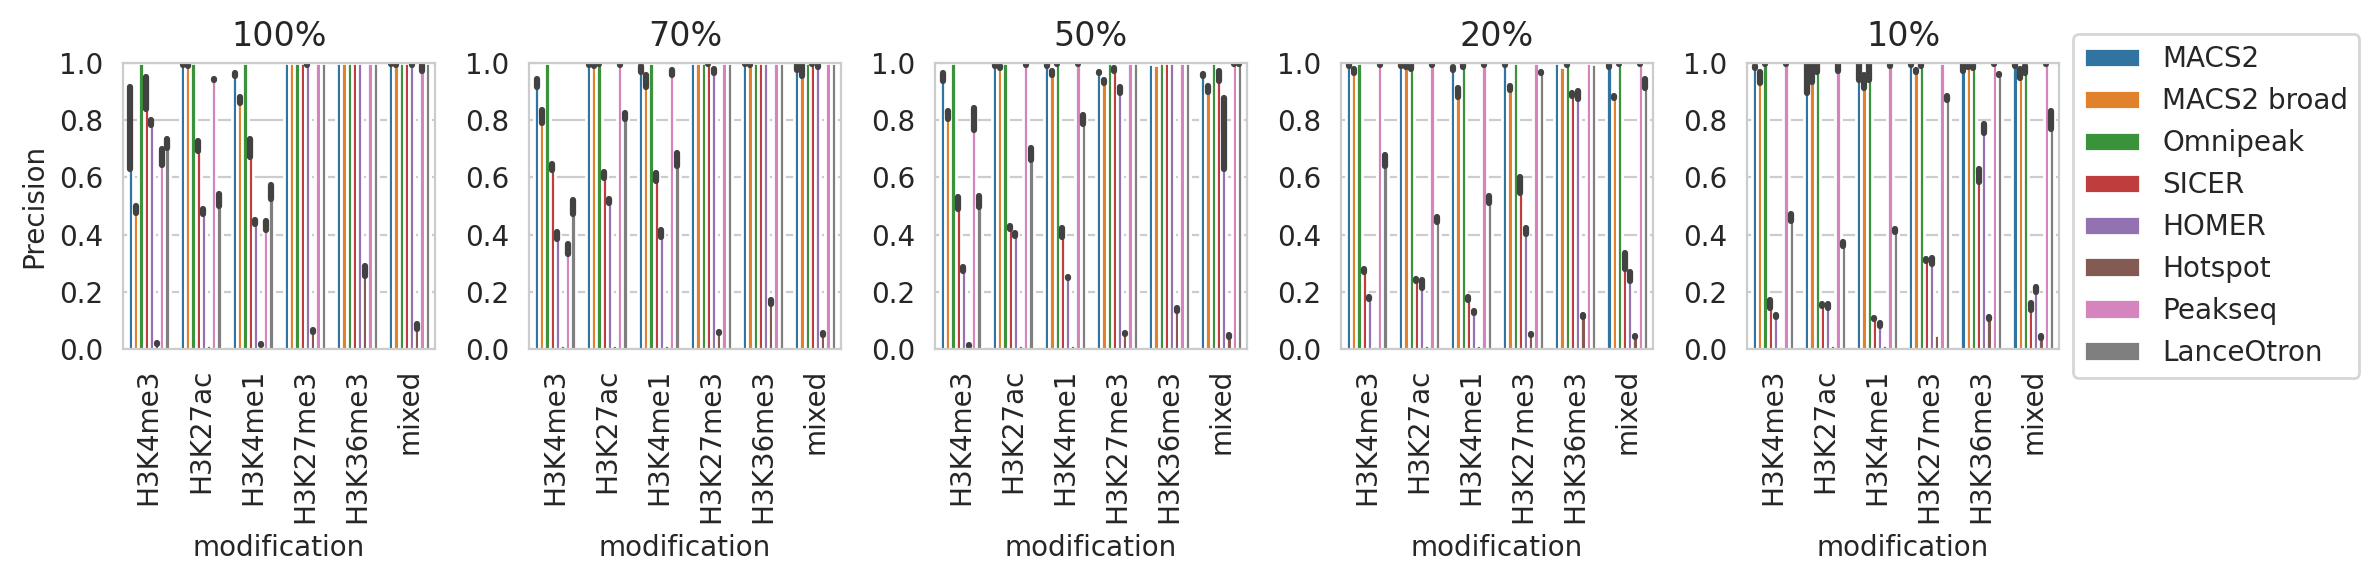

Recall


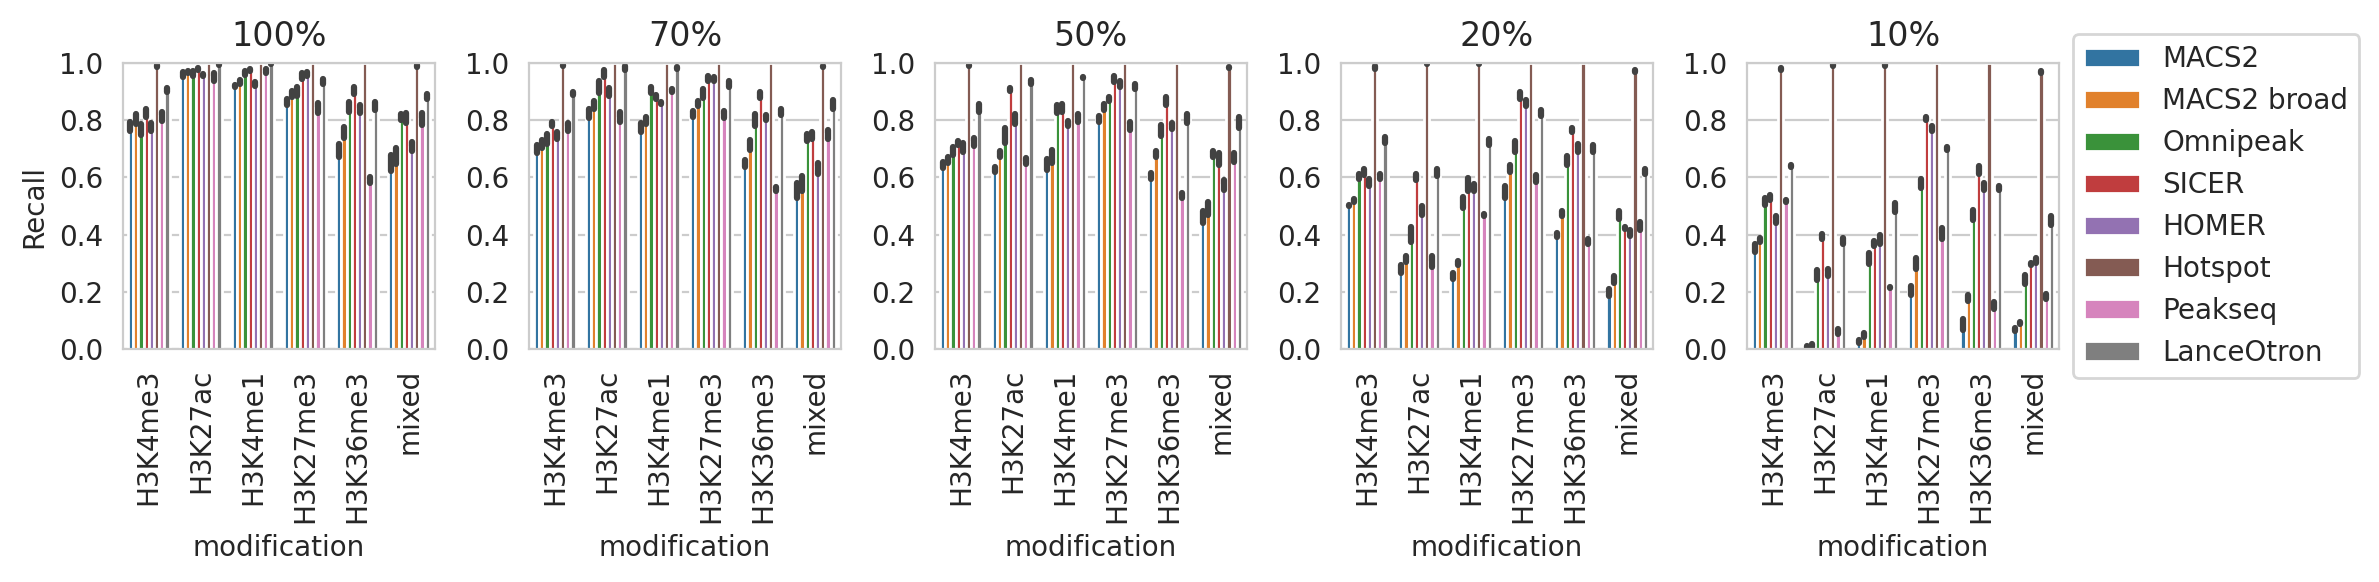

F1


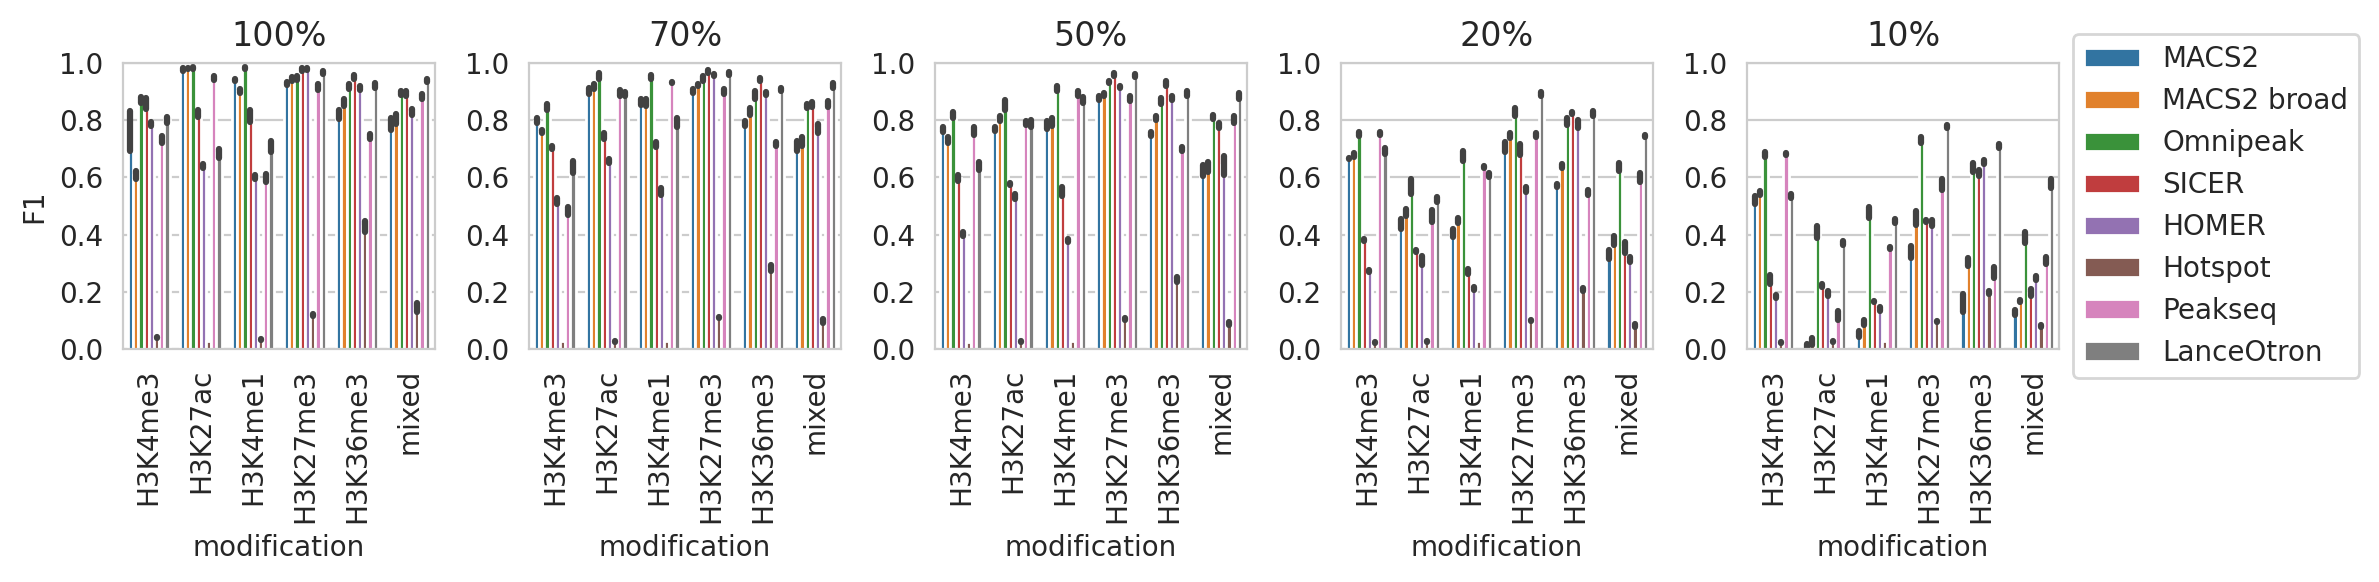

In [75]:
for y in ['Precision', 'Recall', 'F1']:
    print(y)
    plt.figure(figsize=(12, 3))
    axs = [plt.subplot(1, 5, i + 1) for i in range(5)]
    for i, q in enumerate(df_peaks['quality'].unique()):
        if q == '0%':
            continue
        ax = axs[i]
        sns.barplot(data=df_peaks[(df_peaks['quality'] == q)], x="modification", y=y, hue='tool', ax=ax,
                    order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])
        ax.xaxis.set_tick_params(rotation=90)
        ax.set_title(f'{q}')
        # Put a legend to the right of the current axis
        if i == len(axs) - 1:
            ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        else:
            ax.legend().set_visible(False)
        if i > 0:
            ax.set_ylabel(None)
        ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(os.path.join(FIGURES_DIR, f'{y}.pdf'), bbox_inches='tight', dpi=300)
    plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

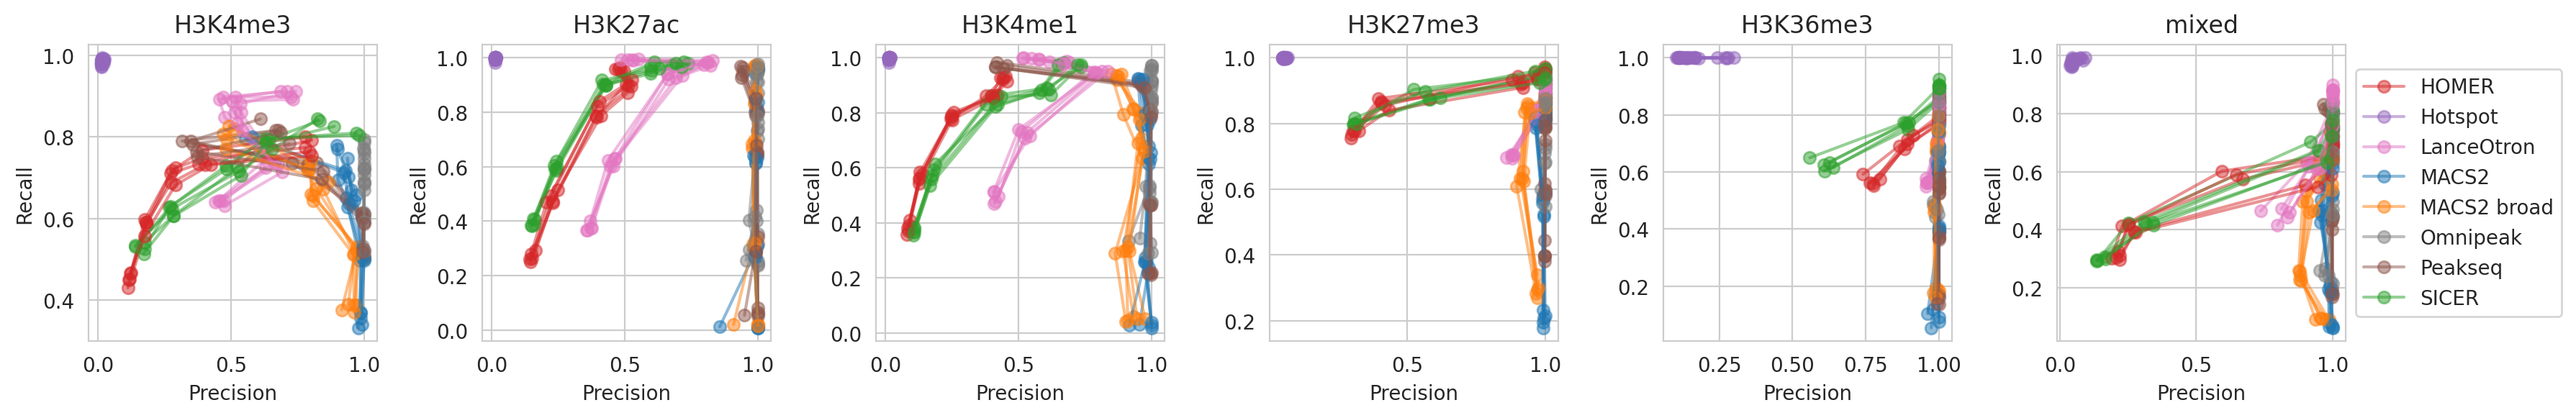

In [76]:
plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for (n, tool), dft in df_peaks[df_peaks['modification'] == m].groupby(['n', 'tool']):
        if m == 'mixed' and tool not in labels:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.5)
            labels.append(tool)
        else:
            ax.plot(dft['Precision'], dft['Recall'], marker='o', color=TOOLS_PALETTE[tool], alpha=0.5)
        ax.set_xlabel('Precision')
        ax.set_ylabel('Recall')
        ax.set_title(f'{m}')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

  0%|          | 0/6 [00:00<?, ?it/s]

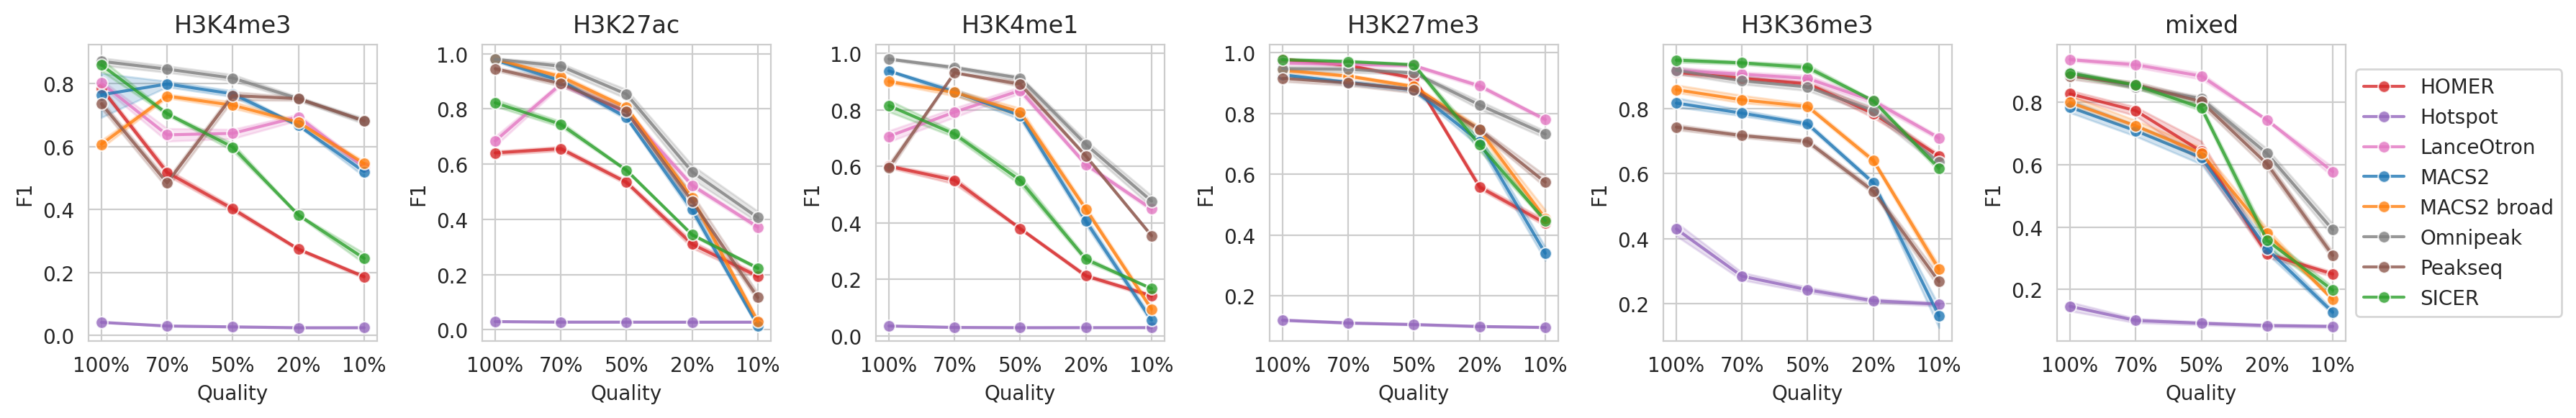

In [77]:
plt.figure(figsize=(18, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
labels = []  # Hack to add labels only once 
for i, m in enumerate(tqdm(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'])):
    ax = axs[i]
    for tool, dft in df_peaks[df_peaks['modification'] == m].groupby('tool'):
        if m == 'mixed' and tool not in labels:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
            labels.append(tool)
        else:
            sns.lineplot(dft, x='quality', y='F1', marker='o', label=tool, color=TOOLS_PALETTE[tool], alpha=0.8, ax=ax)
    ax.set_xlabel('Quality')
    ax.set_ylabel('F1')
    ax.set_title(f'{m}')
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))        
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'auc.pdf'), bbox_inches='tight', dpi=300)
plt.show()

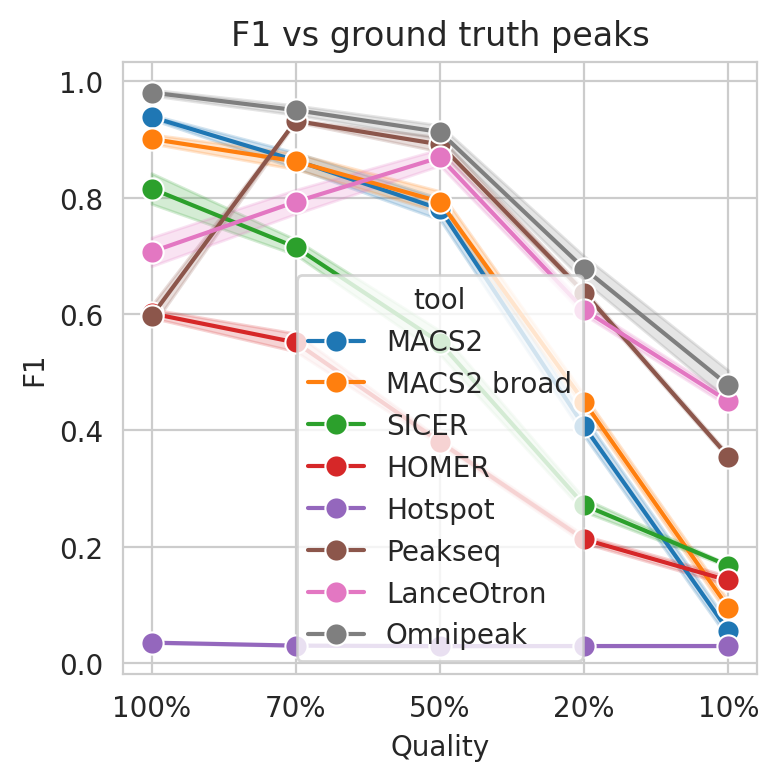

In [78]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=df_peaks[df_peaks['modification'] == 'H3K4me1'], x="quality", y="F1", hue='tool',
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('F1 vs ground truth peaks')
plt.xlabel('Quality')
plt.ylabel('F1')
plt.tight_layout()
plt.show()

In [79]:
t = []
for (m, n, tool), dft in tqdm(list(df_peaks0[df_peaks0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    f1prev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['F1'] + f1prev) / 2
        mprev, f1prev = row['multiplier'], row['F1']
    t.append((m, n, tool, aj))
dff1auc = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dff1auc.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

modification  n     tool       AUC
238        mixed  5  Peakseq  0.678756
123      H3K4me1  1    MACS2  0.643546
174      H3K4me3  2  Peakseq  0.647135

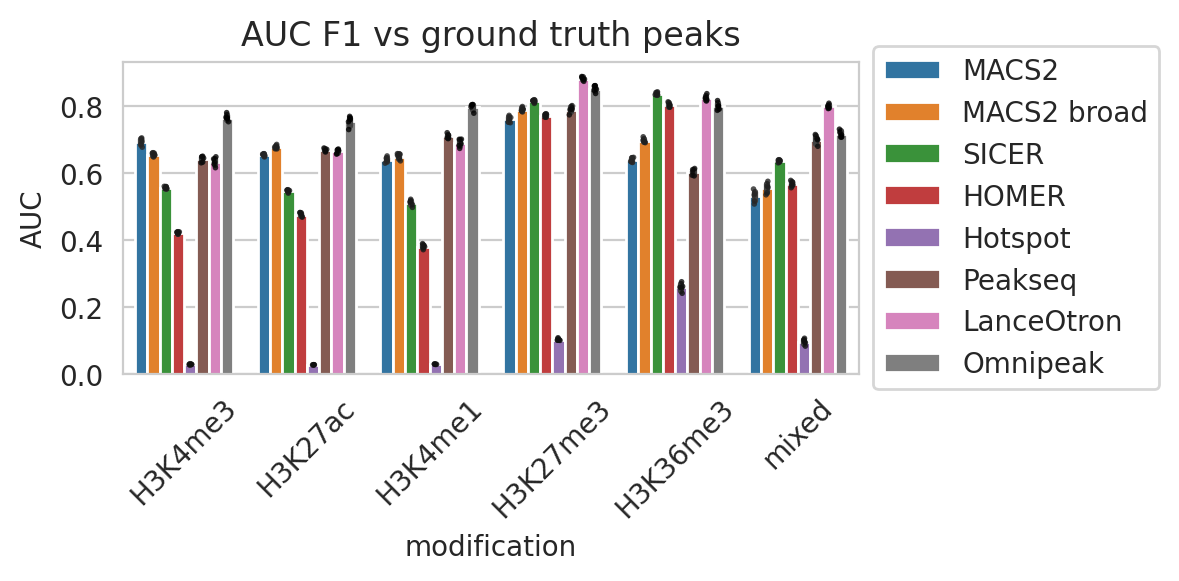

In [80]:
plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.title.set_text('AUC F1 vs ground truth peaks')
sns.barplot(data=dff1auc, x='modification', y='AUC',hue='tool',
            # capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=dff1auc, x='modification', y='AUC',hue='tool',
              dodge=True, size=2, color="black", alpha=0.8,
              palette="dark:black",
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# Overlap vs 100% quality peaks

In [81]:
rows = []
tf = tempfile.mktemp()
for (m, n, t), dft in tqdm(list(df_peaks.groupby(['modification', 'n', 'tool']))):
    print(m, n, t)
    peaks_file100 = dft[dft['multiplier'] == 1.0]['file'].values[0]
    for _, (file, mult) in dft[dft['multiplier'] != 1.0][['file', 'multiplier']].iterrows():
        peaks100 = lines(peaks_file100)
        length100 = bedl(peaks_file100).sum()
        peaks = lines(file)
        length = bedl(file).sum()
        peaks_file100_s = sorted_file(peaks_file100)
        # print(file, peaks_file100)
        file_s = sorted_file(file)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wa -u > {tf}
        overlap100 = lines(tf)
        !bedtools intersect -b {peaks_file100_s} -a {file_s} -wa -u > {tf}
        overlap = lines(tf)
        !bedtools intersect -a {peaks_file100_s} -b {file_s} -wo > {tf}
        overlap_len = int(last_col(tf).sum())
        !rm {peaks_file100_s} {file_s} {tf}
        rows.append((m, n, t, mult, peaks_file100, peaks100, length100, peaks, length, overlap100, overlap, overlap_len))

overlap100_df = pd.DataFrame(rows, columns=['modification', 'n', 'tool', 'multiplier',
                             'peaks_file100', 'peaks100', 'length100',
                             'peaks', 'length',
                             'overlap100', 'overlap', 'overlap_len'])
del rows

overlap100_df['Precision'] = overlap100_df['overlap'] / overlap100_df['peaks']
overlap100_df['Recall'] = overlap100_df['overlap100'] / overlap100_df['peaks100']
overlap100_df['F1'] = [2 / (1 / p + 1 / r) if min(p, r) > 0 else 0 for p, r in zip(overlap100_df['Precision'], overlap100_df['Recall'])]
overlap100_df['Jaccard'] = overlap100_df['overlap_len'] / (overlap100_df['length100'] + overlap100_df['length'] - overlap100_df['overlap_len'])
overlap100_df['quality'] = [f'{int(m * 100)}%' for m in overlap100_df['multiplier']]

overlap100_df.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

H3K27ac 1 HOMER
H3K27ac 1 Hotspot
H3K27ac 1 LanceOtron
H3K27ac 1 MACS2
H3K27ac 1 MACS2 broad
H3K27ac 1 Omnipeak
H3K27ac 1 Peakseq
H3K27ac 1 SICER
H3K27ac 2 HOMER
H3K27ac 2 Hotspot
H3K27ac 2 LanceOtron
H3K27ac 2 MACS2
H3K27ac 2 MACS2 broad
H3K27ac 2 Omnipeak
H3K27ac 2 Peakseq
H3K27ac 2 SICER
H3K27ac 3 HOMER
H3K27ac 3 Hotspot
H3K27ac 3 LanceOtron
H3K27ac 3 MACS2
H3K27ac 3 MACS2 broad
H3K27ac 3 Omnipeak
H3K27ac 3 Peakseq
H3K27ac 3 SICER
H3K27ac 4 HOMER
H3K27ac 4 Hotspot
H3K27ac 4 LanceOtron
H3K27ac 4 MACS2
H3K27ac 4 MACS2 broad
H3K27ac 4 Omnipeak
H3K27ac 4 Peakseq
H3K27ac 4 SICER
H3K27ac 5 HOMER
H3K27ac 5 Hotspot
H3K27ac 5 LanceOtron
H3K27ac 5 MACS2
H3K27ac 5 MACS2 broad
H3K27ac 5 Omnipeak
H3K27ac 5 Peakseq
H3K27ac 5 SICER
H3K27me3 1 HOMER
H3K27me3 1 Hotspot
H3K27me3 1 LanceOtron
H3K27me3 1 MACS2
H3K27me3 1 MACS2 broad
H3K27me3 1 Omnipeak
H3K27me3 1 Peakseq
H3K27me3 1 SICER
H3K27me3 2 HOMER
H3K27me3 2 Hotspot
H3K27me3 2 LanceOtron
H3K27me3 2 MACS2
H3K27me3 2 MACS2 broad
H3K27me3 2 Omnipea

modification  n        tool  multiplier  \
897        mixed  4       HOMER         0.5   
373     H3K36me3  2    Omnipeak         0.5   
394     H3K36me3  3  LanceOtron         0.2   

                                         peaks_file100  peaks100  length100  \
897  /home/jetbrains/data/2023_chips/homer/mixed_k4...       371    2466481   
373  /home/jetbrains/data/2023_chips/omnipeak/H3K36...       512    6366200   
394  /home/jetbrains/data/2023_chips/lanceotron/H3K...      5330    4814854   

     peaks     length  overlap100  overlap  overlap_len  Precision    Recall  \
897    388  2340255.0         285      333      2288872   0.858247  0.768194   
373    500  6097300.0         427      487      6059700   0.974000  0.833984   
394   5145  3910956.0        4466     4957      3300677   0.963460  0.837899   

           F1   Jaccard quality  
897  0.810728  0.909053     50%  
373  0.898571  0.946266     50%  
394  0.896303  0.608405     20%

In [82]:
overlap100_df0 = overlap100_df.copy()
# Add 1.0 and 0.0 multiplier
for m, n, tool in product(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'], range(1, 6), TOOLS):
    row = [m, n, tool, 0.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    row = [m, n, tool, 1.0] + [None] * (len(overlap100_df0.columns) - 4)
    overlap100_df0.loc[len(overlap100_df0)] = row
    
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'quality'] = '0%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'quality'] = '100%'
overlap100_df0.loc[overlap100_df0['multiplier'] == 0, 'Jaccard'] = 0
overlap100_df0.loc[overlap100_df0['multiplier'] == 1.0, 'Jaccard'] = 1
overlap100_df0.sort_values(by=['modification', 'n', 'tool', 'multiplier'], ascending=False, inplace=True)
overlap100_df0.tail(3)

/tmp/ipykernel_674383/3784053421.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  overlap100_df0.loc[len(overlap100_df0)] = row
/tmp/ipykernel_674383/3784053421.py:7: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  overlap100_df0.loc[len(overlap100_df0)] = row
/tmp/ipykernel_674383/3784053421.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result

modification  n   tool  multiplier  \
2         H3K27ac  1  HOMER         0.2   
3         H3K27ac  1  HOMER         0.1   
1046      H3K27ac  1  HOMER         0.0   

                                          peaks_file100 peaks100 length100  \
2     /home/jetbrains/data/2023_chips/homer/H3K27ac_...     1006   1037807   
3     /home/jetbrains/data/2023_chips/homer/H3K27ac_...     1006   1037807   
1046                                               None     None      None   

     peaks    length overlap100 overlap overlap_len  Precision    Recall  \
2     1052  829350.0        250     259      398937   0.246198  0.248509   
3     1080  643839.0        143     174      156415   0.161111  0.142147   
1046  None       NaN       None    None        None        NaN       NaN   

            F1   Jaccard quality  
2     0.247348  0.271715     20%  
3     0.151036  0.102552     10%  
1046       NaN  0.000000      0%

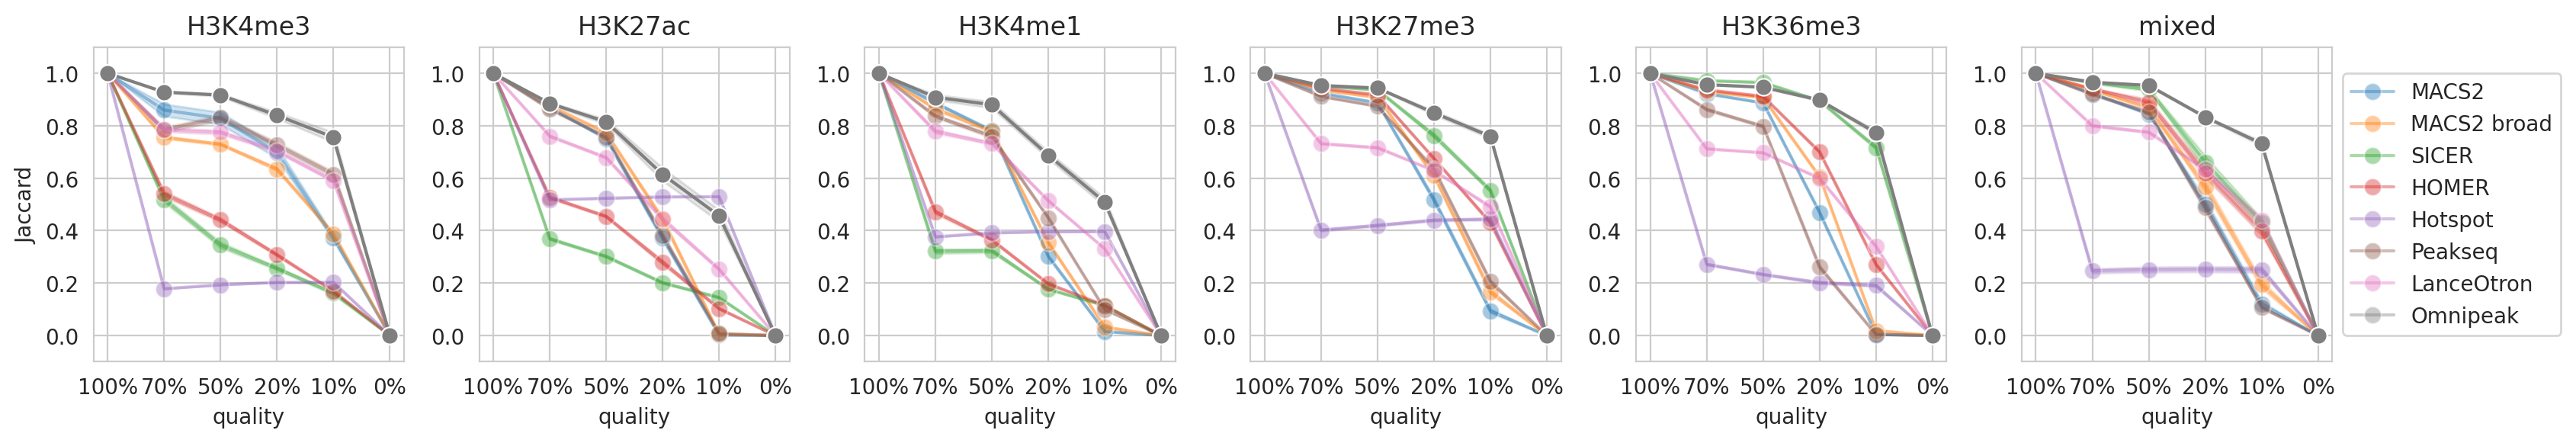

In [83]:
plt.figure(figsize=(17, 3))
axs = [plt.subplot(1, 6, i + 1) for i in range(6)]
for i, m in enumerate(['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed']):
    ax = axs[i]
    sns.lineplot(data=overlap100_df0[(overlap100_df0['modification'] == m) &
                                     (overlap100_df0['tool'] != 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE,
                 errorbar='se',
                 alpha=0.4,
                 marker='o', markersize=8)
    sns.lineplot(data=overlap100_df0[(overlap100_df0['modification'] == m) &
                                     (overlap100_df0['tool'] == 'Omnipeak')], x="quality", y="Jaccard", hue='tool', ax=ax,
                 hue_order=TOOLS,
                 palette=TOOLS_PALETTE, legend=False,
                 errorbar='se',
                 marker='o', markersize=8)
    
    ax.set_title(f'{m}')
    ax.set_ylim([-0.1, 1.1])
    # Put a legend to the right of the current axis
    if i == 5:
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    else:
        ax.legend().set_visible(False)
    if i > 0:
        ax.set_ylabel(None)
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

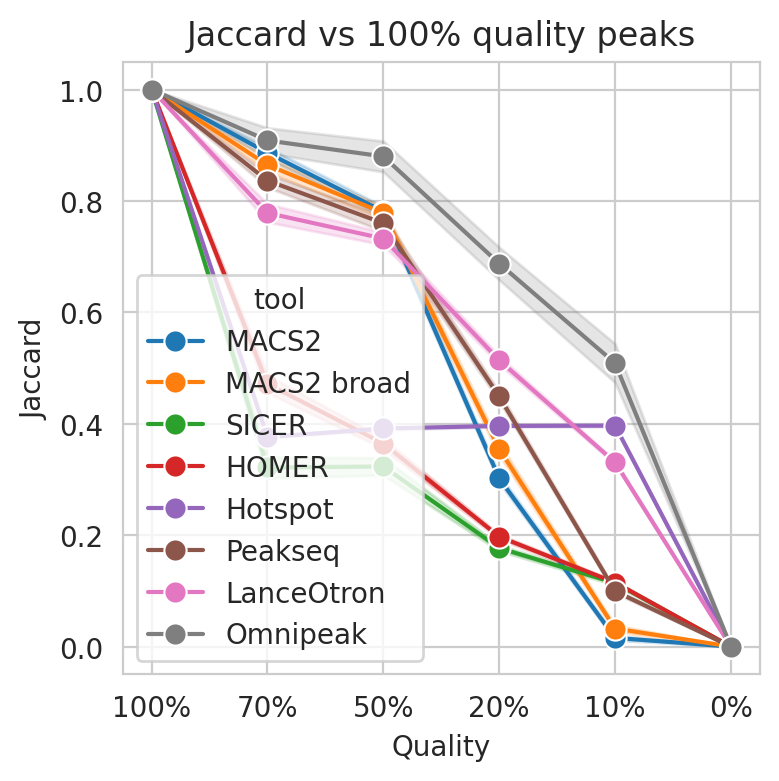

In [84]:
plt.figure(figsize=(4, 4))
sns.lineplot(data=overlap100_df0[overlap100_df0['modification'] == 'H3K4me1'], x="quality", y="Jaccard", hue='tool',
             hue_order=TOOLS,
             palette=TOOLS_PALETTE,
             errorbar='sd', marker='o', markersize=8)
plt.title('Jaccard vs 100% quality peaks')
plt.xlabel('Quality')
plt.ylabel('Jaccard')
plt.tight_layout()
plt.show()

In [85]:
t = []
for (m, n, tool), dft in tqdm(list(overlap100_df0[overlap100_df0['quality'] != '0%'].groupby(['modification', 'n', 'tool']))):
    aj = 0
    mprev = 0
    jprev = 0
    for _, row in dft.sort_values(by=['multiplier']).iterrows():
        aj += (row['multiplier'] - mprev) * (row['Jaccard'] + jprev) / 2
        mprev, jprev = row['multiplier'], row['Jaccard']
    t.append((m, n, tool, aj))
dfjaccardauc100 = pd.DataFrame(data=t, columns=['modification', 'n', 'tool', 'AUC'])
dfjaccardauc100.sample(3)

  0%|          | 0/240 [00:00<?, ?it/s]

modification  n        tool       AUC
151      H3K4me1  4       SICER  0.348605
114     H3K36me3  5  LanceOtron  0.654547
120      H3K4me1  1       HOMER  0.417740

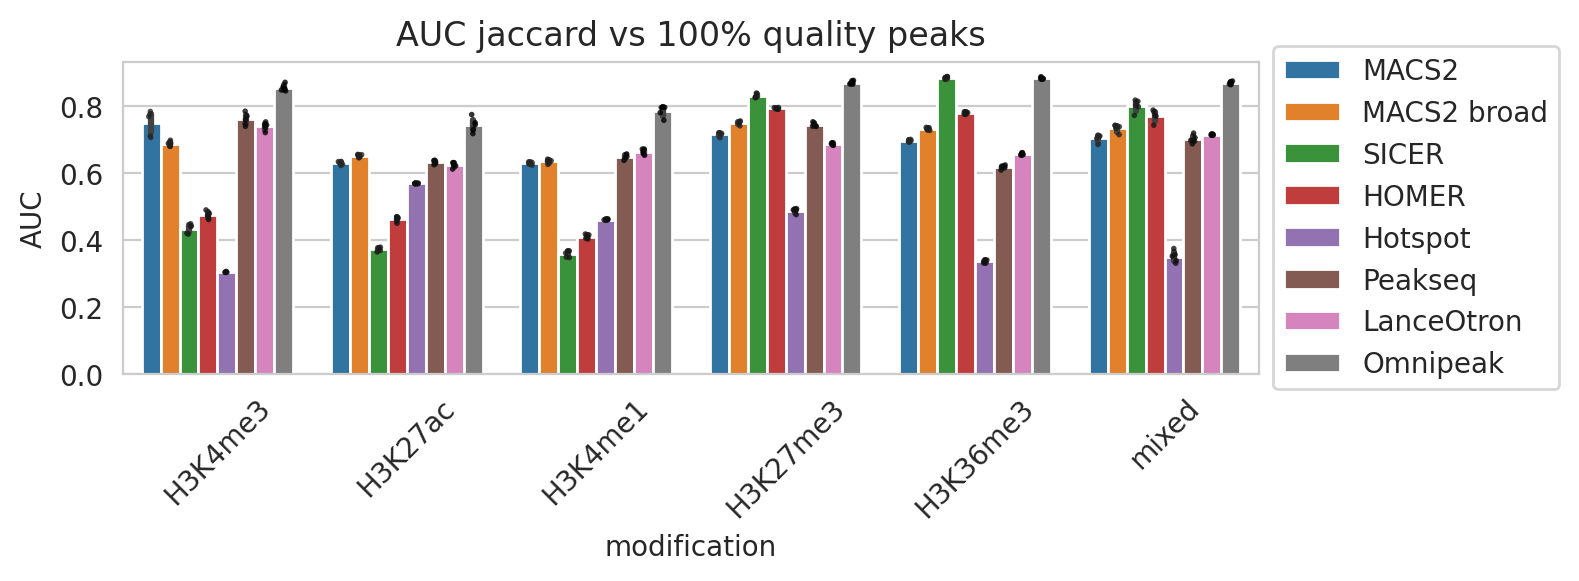

In [86]:
plt.figure(figsize=(8, 3))
ax = plt.axes()
ax.title.set_text('AUC jaccard vs 100% quality peaks')
sns.barplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
            # capsize=.05, err_kws={'linewidth': 2},
            palette=TOOLS_PALETTE,
            order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
            hue_order=TOOLS,
            ax=ax)
sns.stripplot(data=dfjaccardauc100, x='modification', y='AUC', hue='tool',
              dodge=True, size=2, color="black", alpha=0.8, palette='dark:black',
              order=['H3K4me3', 'H3K27ac', 'H3K4me1', 'H3K27me3', 'H3K36me3', 'mixed'],
              hue_order=TOOLS, legend=False,
              ax=ax)
ax.xaxis.set_tick_params(rotation=45)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig(os.path.join(FIGURES_DIR, f'jaccard_auc2.pdf'), bbox_inches='tight', dpi=300)
plt.show()

# DONE